In [1]:
"""
We can assume the target is in line of sight for the cannon!
We don't care at all about the yaw; ONLY the pitch of the cannon.
Basically, a straight line from the cannon to the target.

We are also given the distance. (manually or through rangefinder/raycaster)
We only need to simulate UP, because you can hit super close shots without assistance.

Steel Medcannon velocity is 360m/s according to endal, which is 1.5x faster than a 6-charge steel cannon
"""

"\nWe can assume the target is in line of sight for the cannon!\nWe don't care at all about the yaw; ONLY the pitch of the cannon.\nBasically, a straight line from the cannon to the target.\n\nWe are also given the distance. (manually or through rangefinder/raycaster)\nWe only need to simulate UP, because you can hit super close shots without assistance.\n\nSteel Medcannon velocity is 360m/s according to endal, which is 1.5x faster than a 6-charge steel cannon\n"

In [2]:
# let x be target position (we dont care about z, and our y = target y)
# let x0 be cannon position
# let n be number of powder charges in cannon
# (160 m/s -> 8 blocks / tick)
# So 220 m/s -> 11 blocks / tick

# d(istance) = x0 - x
# V(elocity) = n (blocks per tick)

# cannon goes from 0 to 60 degrees (we only aim up)
# Let A be angle claiming to be a
# Vx = cos(A) * V
# Vy = sin(A) * V

# T(ime) to target = t
# t = |ln(1-d/(100*Vw))/ln(0.99)| = |ln(1-d/(100*Vw))/(-0.010050335853501)| (ticks)
# T = t2 = f(y0,y,Vy) -> time that projectile is _actually_ in the air
# Δt = |t-t2|
# Best A is a where Δt is smallest (α = A)
# Defining f(y0,y,Vy):
#   With each tick, the speed decreases by 1% by air resistance and by 0.05 blocks/tick by gravitation
#   So we need to simulate it
#   let τ is number of ticks since projectile is released


In [3]:
# No need, also, it makes the calculations take 12x as long, 
# without changing the outcome in my use-case. 
# --> you'd need -30 pitch for those (I don't care)

# def calculate_time_in_air(muzzle_y, Vy):
#     t = 0
#     if muzzle_y <= 0:
#         while t < 100000: # Endless calculation protection
#             muzzle_y += Vy
#             Vy = 0.99 * Vy - 0.05
#             t += 1
#             if muzzle_y > 0:
#                 break

#     while t < 100000: # Endless calculation protection
#         muzzle_y += Vy
#         Vy = 0.99 * Vy - 0.05
#         t += 1
#         if muzzle_y <= 0:
#             return t

#     return None

In [4]:
    # ruined by the delta time > 1 threshold
    # for i in range(len(precision_steps)):
    #     if pitch == None:
    #         min_p, max_p = min_pitch, max_pitch
    #     else:
    #         min_p = max(min_pitch, pitch - precision_steps[i - 1])
    #         max_p = min(max_pitch, pitch + precision_steps[i - 1])

    #     pitch = calculate_pitch(
    #         distance=distance,
    #         initial_velocity=initial_velocity,
    #         cannon_length=cannon_length,
    #         min_pitch=min_p,
    #         max_pitch=max_p,
    #         step_size=precision_steps[i],
    #     )

    #     if pitch == None:
    #         break

In [5]:
# TODO: maybe also discard some higher pitches, because they have terrible dTs
#       --> it seems that for most pitches except those very close to max range
#           the pitch is < 15(!) PLEASE CONFIRM!
#       --> this is wrong; it's not very close to max range, but it does follow
#           a trend (check in graph using different velocities)

# also find the required RPM to move to the correct angle + if it's more than 256/8, do it in chunks.
# maximise RPM for speeeed!

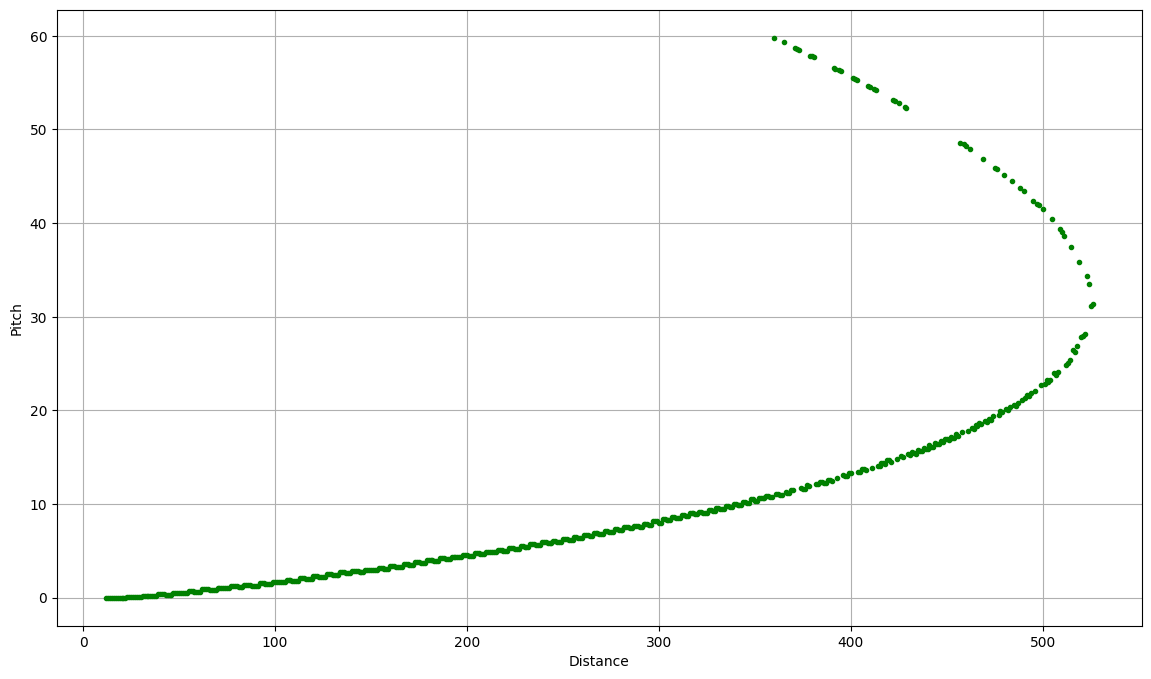

Estimated max range: 644
Simulated max range: 526.0


In [6]:
import matplotlib.pyplot as plt
from math import sin, cos, atan, sqrt, pi, radians, log
from numpy import linspace, arange


# TODO: check https://github.com/Malex21/CreateBigCannons-BallisticCalculator/blob/main/calculator.py
# newest ver: many fixes and improvements, specifically, check the commits and what they do


def custom_linspace(start, stop, num):
    # @Malex21's linspace implementation
    result = [start]
    delta = (stop - start) / num
    for _ in range(num - 1):
        result.append(result[-1] + delta)
    result.append(stop)
    return result


def estimate_max_range(
    cannon_length,
    initial_velocity,
    assumed_ideal_angle,
):
    # Ensures that 0 < (1 - (distance - muzzle_x) / (100 * Vx)) < 1
    # This is a conservative upper bound due to the assumptions.

    ideal_muzzle_x = cannon_length * cos(radians(assumed_ideal_angle))
    ideal_Vx = initial_velocity * cos(radians(assumed_ideal_angle))

    estimated_max_range = 0
    upperbound = 100000  # Arbitrary

    while estimated_max_range < upperbound:
        tried_distance = (estimated_max_range + upperbound) // 2

        if (tried_distance - ideal_muzzle_x) / (100 * ideal_Vx) >= 1:
            upperbound = tried_distance - 1
        else:
            estimated_max_range = tried_distance + 1

    return estimated_max_range


def calculate_time_in_air(projectile_y, Vy):
    # Since we assume the cannon is on the same level as the target,
    # only simulate until the projectile is at ground level.
    t = 0
    while t < 100000:  # Endless calculation protection
        projectile_y += Vy
        Vy = 0.99 * Vy - 0.05
        t += 1
        if projectile_y <= 0:
            return t

    return None


def calculate_pitch(
    distance, initial_velocity, cannon_length, min_pitch, max_pitch, step_size
):

    delta_times = []
    for tried_pitch in custom_linspace(
        min_pitch, max_pitch, int(abs(min_pitch - max_pitch) / step_size)
    ):
        tried_pitch_rad = radians(tried_pitch)
        Vx = initial_velocity * cos(tried_pitch_rad)
        Vy = initial_velocity * sin(tried_pitch_rad)

        # Account for x position changing when changing pitch
        muzzle_x = cannon_length * cos(tried_pitch_rad)

        distance_Vx_ratio = (distance - muzzle_x) / (100 * Vx)
        if distance_Vx_ratio < 1:
            time_to_target = abs(log(1 - distance_Vx_ratio) / (-0.010050335853501))
        else:
            continue

        muzzle_y = cannon_length * sin(tried_pitch_rad)
        time_in_air = calculate_time_in_air(muzzle_y, Vy)
        if time_in_air == None:
            continue

        delta_time = abs(time_to_target - time_in_air)
        delta_times.append((delta_time, tried_pitch))

    if len(delta_times) == 0:
        return None, None
    else:
        best_delta_time, pitch = min(delta_times, key=lambda x: x[0])
        return best_delta_time, pitch


def calculate_all_ballistics(
    initial_velocity,
    cannon_length,
    min_pitch,
    max_pitch,
    pitch_steps,
    delta_time_threshold,
    distance_step,
    estimated_max_range,
):
    distances_and_pitches = []
    for distance in custom_linspace(
        cannon_length + 1,
        estimated_max_range,
        int(abs(cannon_length + 1 - estimated_max_range) / distance_step),
    ):
        pitch = None
        for i in range(len(pitch_steps)):
            if pitch == None:
                min_p, max_p = min_pitch, max_pitch
            else:
                min_p = max(min_pitch, pitch - pitch_steps[i - 1])
                max_p = min(max_pitch, pitch + pitch_steps[i - 1])

            best_delta_time, pitch = calculate_pitch(
                distance,
                initial_velocity,
                cannon_length,
                min_p,
                max_p,
                pitch_steps[i],
            )

            if pitch == None:
                break

        # If pitch is non-existent or delta time is shit, assume it's not going to improve.
        if pitch == None or best_delta_time > delta_time_threshold:
            break

        distances_and_pitches.append((distance, pitch))

    return distances_and_pitches


# Don't calculate lower pitches, due to the direct line of sight assumption.
# High pitches result in worse delta times, so don't bother.
velocity_ms = 160
cannon_length = 11
min_pitch = 0
# max_pitch = 35
max_pitch = 60

# Velocity per tick
initial_velocity = velocity_ms / 20

# Large pitch step size requires higher best_delta_time threshold
# Extremely small steps will increase calculation time
# pitch_steps = [3, 1, 0.1]
pitch_steps = [0.1]
distance_step = 1.0
delta_time_threshold = 1.0

# Useful when delta_time_threshold is high
estimated_max_range = estimate_max_range(
    cannon_length,
    initial_velocity,
    37.325,
)

distances_and_pitches = calculate_all_ballistics(
    initial_velocity,
    cannon_length,
    min_pitch,
    max_pitch,
    pitch_steps,
    delta_time_threshold,
    distance_step,
    estimated_max_range,
)

distances = [dp[0] for dp in distances_and_pitches]
pitches = [dp[1] for dp in distances_and_pitches]

plt.figure(figsize=(14, 8))
plt.plot(distances, pitches, marker=".", linestyle="", color="green")
plt.xlabel("Distance")
plt.ylabel("Pitch")
plt.grid(True)
plt.show()

print(f"Estimated max range: {estimated_max_range}")
print(f"Simulated max range: {max(distances_and_pitches, key=lambda x: x[0])[0]}")

In [7]:
def lookup_pitch(distances_and_pitches, input_distance):

    if input_distance < distances_and_pitches[0][0]:
        # Target is right in front of you
        return 0

    if input_distance > distances_and_pitches[-1][0]:
        # Target is out of range
        return None

    # Perform binary search because the tables can get pretty large and we
    # want speed, since this function will be called often.
    low = 0
    high = len(distances_and_pitches) - 1
    while low <= high:
        mid = (low + high) // 2
        mid_distance, mid_pitch = distances_and_pitches[mid]

        if input_distance == mid_distance:
            # Exact match
            return mid_pitch
        elif input_distance > mid_distance:
            low = mid + 1
        else:
            high = mid - 1

    # Perform interpolation if not exact match
    distance1, pitch1 = distances_and_pitches[high]
    distance2, pitch2 = distances_and_pitches[low]
    return pitch1 + ((pitch2 - pitch1) / (distance2 - distance1)) * (
        input_distance - distance1
    )


input_distance = 225
lookup_pitch(distances_and_pitches, input_distance)

5.1999999999999975

In [8]:
calculate_pitch(
    input_distance,
    initial_velocity,
    cannon_length,
    min_pitch,
    max_pitch,
    0.1,
)

# TODO: reject high delta time, depends on step size

(0.13129309245556797, 5.1999999999999975)

In [9]:
# TODO: idea: create an option to precalculate all possible ranges (make them whole in this case)
# Basically: you fill in your cannon info etc. Then:
# 1. Precalculate?
#   - We use look-up table and interpolation/restricted calculation
#   - adjustable distance interval (e.g. 1, 2, 3, ..., maxR or 1.0, 1.1, 1.2, ..., maxR)
#           - maybe it's better to divide a range of numbers up in n chunks (aka linspace) --> does cc tweaked have that?
# 2. Nah we ball --> calculate on the fly (might need to be less precise + assume less pitch range (?))
# if the given distance does not match the look-up table, use some interpolation(?)/restricted calculation
# -- since we already know the pitch ranges in between

# option to save / load precalculated info via locally or pastebin